In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
from dataset import *
random_state = 1
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = get_bike_share(random_state)

## Compare with EBM

In [3]:
from interpret.glassbox import ExplainableBoostingRegressor

clf = ExplainableBoostingRegressor(interactions=10)
clf.fit(train_x, train_y)

pred_train = clf.predict(train_x)
pred_test = clf.predict(test_x)
ebm_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(ebm_stat)

[83.09317 85.30501]


## Train GAMI-Net 

In [4]:
%%time

from sklearn.model_selection import cross_val_score

model = GAMINetRegressor(interact_num=10,
                         meta_info=meta_info,
                         subnet_size_main_effect=[20] * 1,
                         subnet_size_interaction=[20] * 2,
                         max_epochs=[1000, 1000, 1000],
                         learning_rates=[0.001, 0.001, 0.0001],
                         early_stop_thres=["auto", "auto", "auto"],
                         batch_size=1000,
                         reg_clarity=0.1,
                         loss_threshold=0.01,
                         normalize=True,
                         warm_start=True,
                         verbose=False,
                         random_state=random_state)
cross_val_score(model, train_x, train_y, cv=5, scoring=lambda est, x, y: get_metric(y, est.predict(x)))

Wall time: 2min 16s


array([75.26965332, 74.03894043, 73.78998566, 73.39002228, 74.0490799 ])

In [ ]:
import time

start = time.time()
model = GAMINetRegressor(interact_num=10,
                         meta_info=meta_info,
                         subnet_size_main_effect=[20] * 1,
                         subnet_size_interaction=[20] * 2,
                         max_epochs=[1000, 1000, 1000],
                         learning_rates=[0.001, 0.001, 0.0001],
                         early_stop_thres=["auto", "auto", "auto"],
                         batch_size=1000,
                         reg_clarity=0.1,
                         loss_threshold=0.01,
                         normalize=True,
                         warm_start=True,
                         verbose=False,
                         random_state=random_state)
model.fit(train_x, train_y)
print(time.time() - start)

In [23]:
model.time_cost

{'warm_start_main_effect': 0.87,
 'fit_main_effect': 1.12,
 'prune_main_effect': 0.03,
 'get_interaction_list': 0.14,
 'add_interaction': 0.15,
 'warm_start_interaction': 5.48,
 'fit_interaction': 11.67,
 'prune_interaction': 0.1,
 'fine_tune_all': 3.76}

In [19]:
model.time_cost

{'warm_start_main_effect': 5.78,
 'fit_main_effect': 1.9,
 'prune_main_effect': 0.02,
 'get_interaction_list': 0.14,
 'add_interaction': 0.15,
 'warm_start_interaction': 8.36,
 'fit_interaction': 13.63,
 'prune_interaction': 0.1,
 'fine_tune_all': 4.33}

In [7]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[71.02162 73.43538]


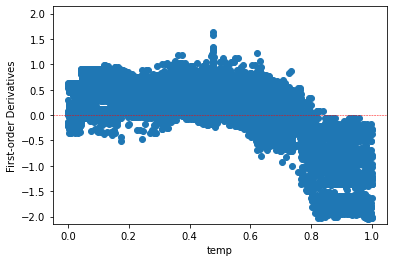

In [8]:
model.partial_derivatives(6)

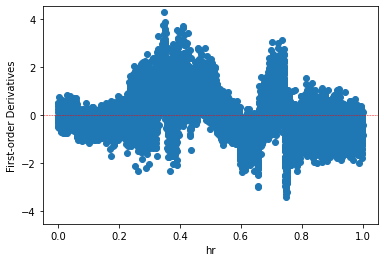

In [9]:
model.partial_derivatives(2)

In [10]:
model.get_mono_loss(train_x), model.certify_mono(n_samples=10000)

(0.0, True)

In [11]:
model.get_clarity_loss(test_x)

0.0005191817763261497

## Visualization

In [12]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

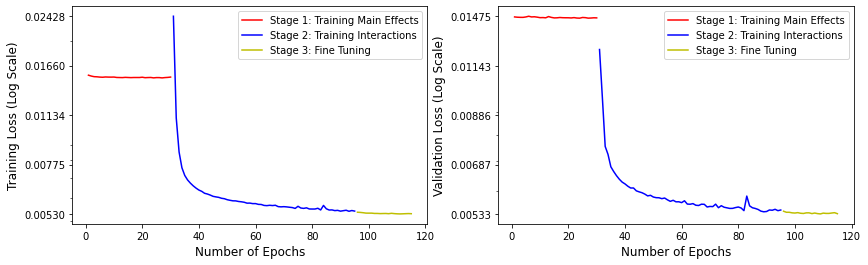

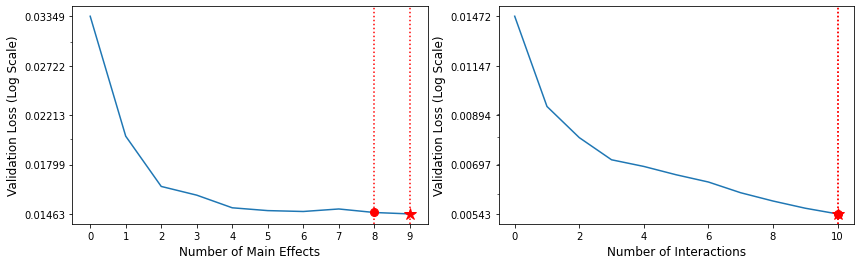

In [13]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

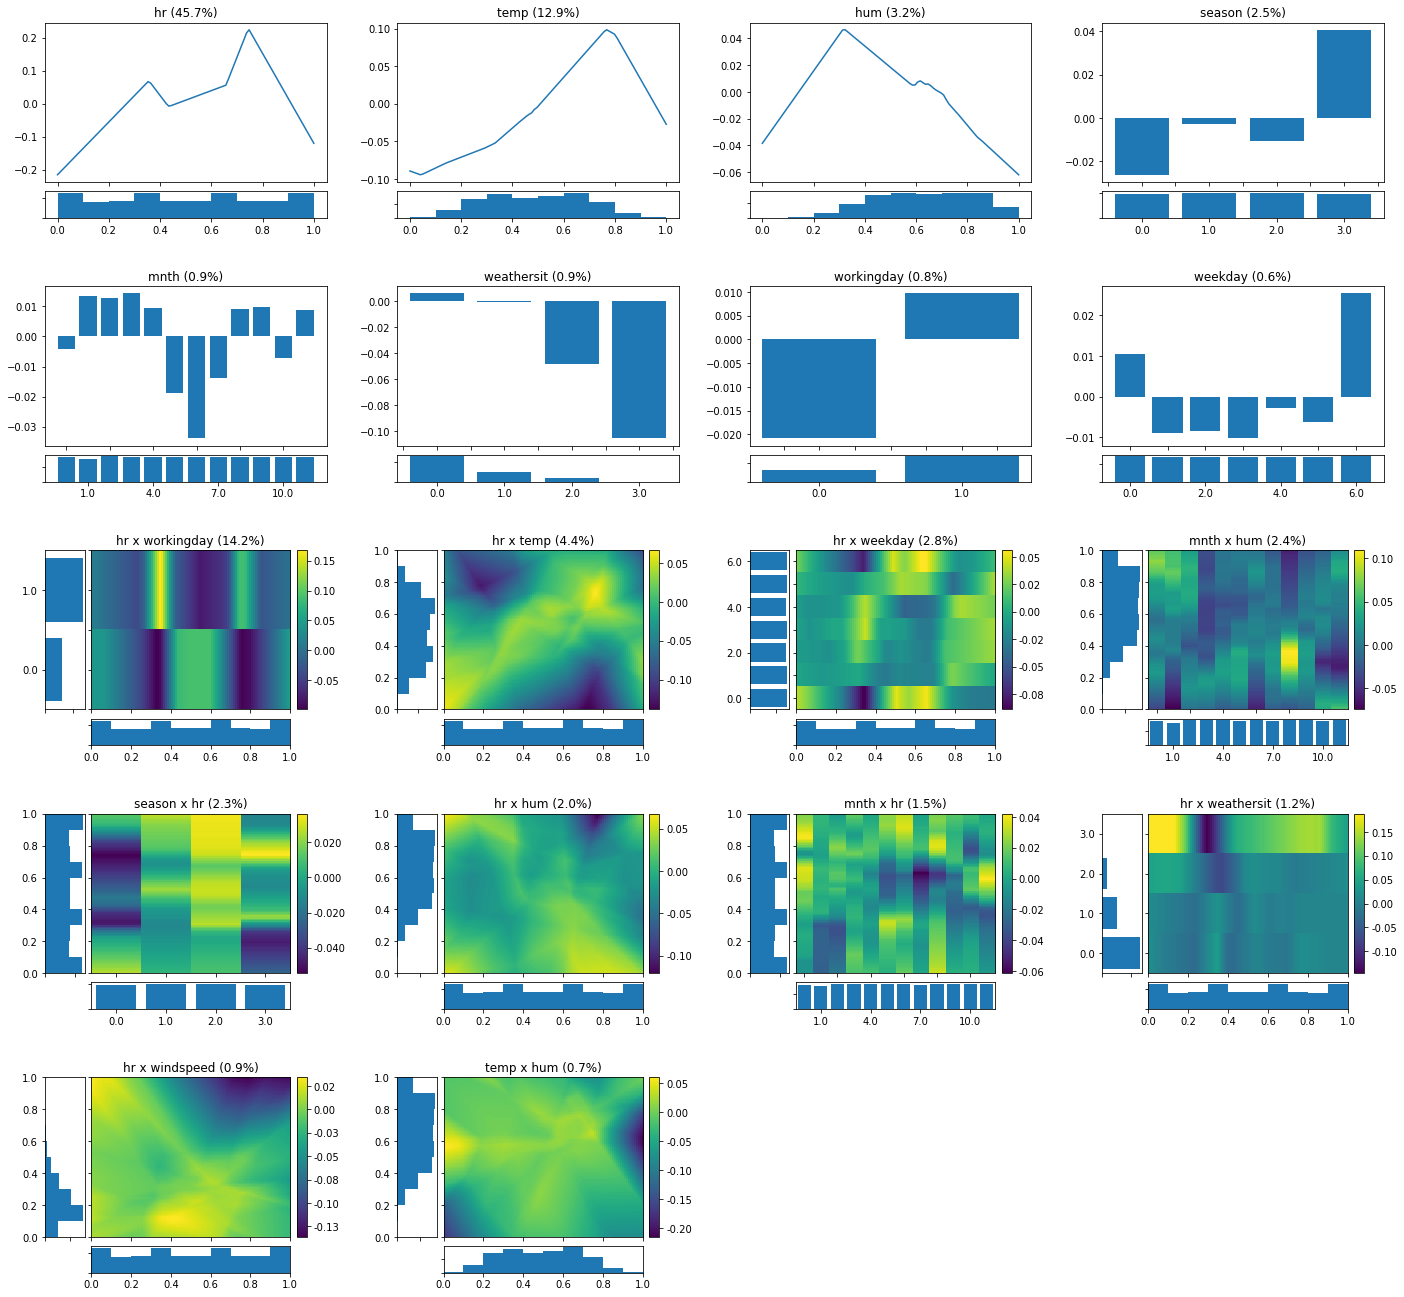

In [14]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, main_effect_num=10, interaction_num=10, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

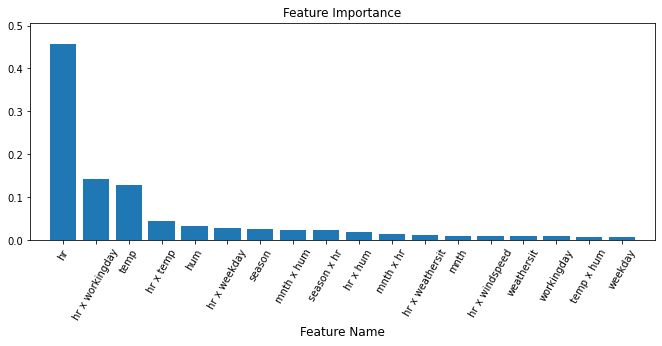

In [15]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [16]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

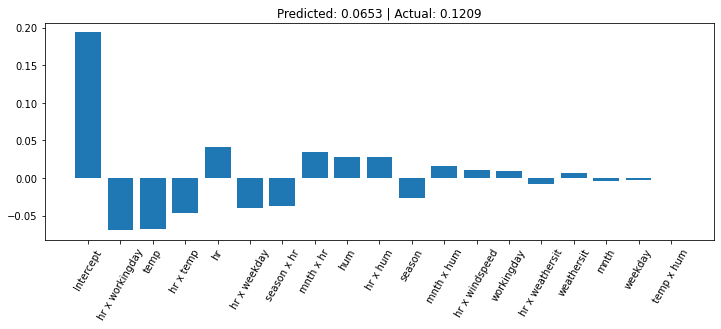

In [17]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')